
# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

Для начала получим токен от kaggle. Чтобы загрузить датасет

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Подключим нужные нам библиотеки и загрузим датасет

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

%matplotlib inline
!kaggle competitions download -c journey-springfield

 99% 518M/521M [00:24<00:00, 25.4MB/s]
100% 521M/521M [00:24<00:00, 22.1MB/s]


У нас появился архивированый файл. Необходимо его разорхивиловать

In [24]:
!ls

journey-springfield.zip  sample_data


In [30]:
import os
import zipfile

data_r = zipfile.ZipFile('journey-springfield.zip', 'r')
data_r.printdir()
data_r.extractall()
os.getcwd()

Выходные данные были обрезаны до нескольких последних строк (5000).
train/simpsons_dataset/moe_szyslak/pic_1025.jpg 2020-04-23 21:01:28        38073
train/simpsons_dataset/moe_szyslak/pic_1026.jpg 2020-04-23 21:01:28        20351
train/simpsons_dataset/moe_szyslak/pic_1027.jpg 2020-04-23 21:01:28        17986
train/simpsons_dataset/moe_szyslak/pic_1028.jpg 2020-04-23 21:01:28        40999
train/simpsons_dataset/moe_szyslak/pic_1029.jpg 2020-04-23 21:01:28        43530
train/simpsons_dataset/moe_szyslak/pic_1030.jpg 2020-04-23 21:01:28        12433
train/simpsons_dataset/moe_szyslak/pic_1031.jpg 2020-04-23 21:01:28        13258
train/simpsons_dataset/moe_szyslak/pic_1032.jpg 2020-04-23 21:01:28        32360
train/simpsons_dataset/moe_szyslak/pic_1033.jpg 2020-04-23 21:01:28        20938
train/simpsons_dataset/moe_szyslak/pic_1034.jpg 2020-04-23 21:01:28        13577
train/simpsons_dataset/moe_szyslak/pic_1035.jpg 2020-04-23 21:01:28        18581
train/simpsons_dataset/moe_szyslak/pic_10

'/content'

In [31]:
!ls

characters_illustration.png  sample_data	    testset
journey-springfield.zip      sample_submission.csv  train


In [7]:
BATCH_SIZE = 256
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")

if torch.cuda.is_available():
    print('CUDA is available! Training on GPU...')
    DEVICE = torch.device("cuda")
else:
    print('CUDA is not available. Training on CPU...')
!nvidia-smi
torch.cuda.is_available()

CUDA is available! Training on GPU...
Sun Feb 26 22:10:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                  

True

In [33]:
N_CORES = 2
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [45]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Данных маловато, нужно увеличить их колличество, чтобы нейросеть обучилась лучше.

In [35]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

Проиллюстрируем данные через диаграмму

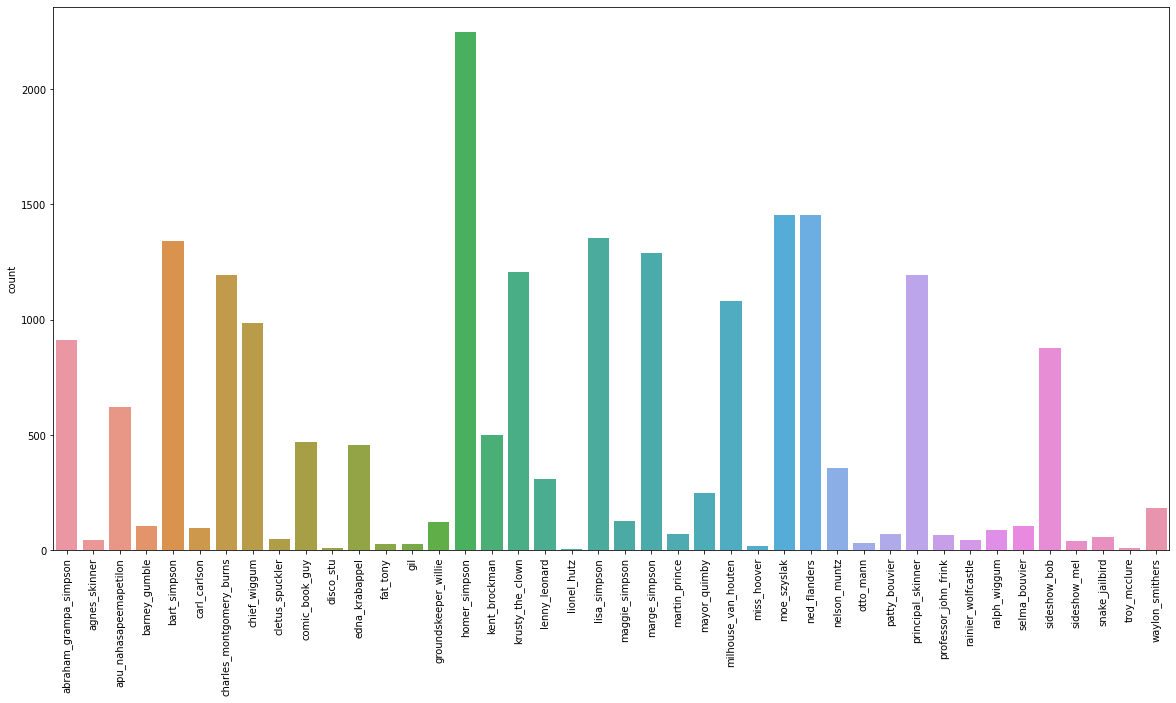

In [47]:
import seaborn as sns
from collections import Counter
data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

Используем Дропаут для увеличения датасета

In [48]:
dropout = transforms.RandomChoice([
        transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    dropout,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

Теперь посчитаем веса, чтобы выровнять количество выборок: чем меньше выборок — тем больше вес в WeightedRandomSampler.

In [49]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

  0%|          | 0/20933 [00:00<?, ?it/s]

In [50]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

  0%|          | 0/369 [00:00<?, ?it/s]

94332 Counter({41: 2330, 14: 2316, 31: 2312, 35: 2309, 18: 2309, 3: 2298, 37: 2298, 7: 2292, 8: 2288, 12: 2284, 19: 2279, 29: 2275, 39: 2272, 24: 2272, 13: 2271, 15: 2270, 6: 2266, 2: 2265, 22: 2265, 4: 2258, 26: 2255, 5: 2255, 32: 2253, 36: 2249, 9: 2239, 38: 2230, 10: 2230, 0: 2228, 23: 2227, 33: 2225, 28: 2222, 21: 2213, 27: 2210, 30: 2196, 1: 2194, 11: 2191, 20: 2188, 17: 2185, 25: 2175, 40: 2156, 34: 2146, 16: 2136})


In [51]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

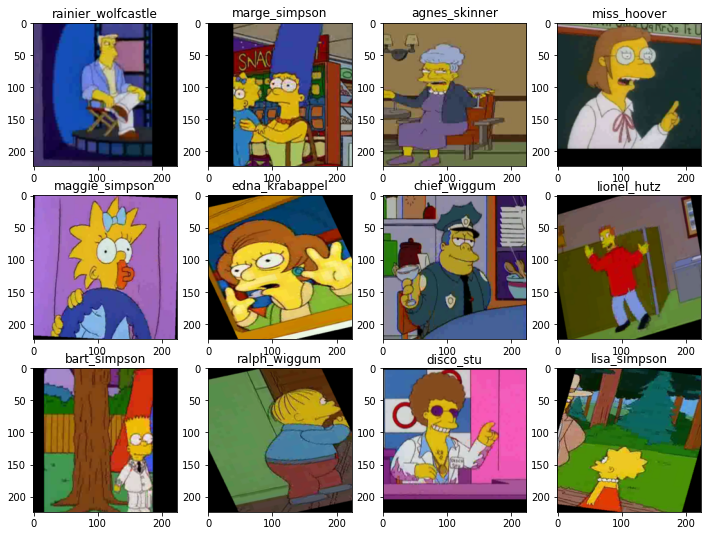

In [52]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

In [55]:
def fit(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [57]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [58]:
n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=2400, out_features=n_classes),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6):

In [62]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [64]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.4864 train_acc 0.6110

Epoch 002 train_loss: 0.6173 train_acc 0.8374

Epoch 003 train_loss: 0.4229 train_acc 0.8872

Epoch 004 train_loss: 0.3197 train_acc 0.9139

Epoch 005 train_loss: 0.2726 train_acc 0.9266

Epoch 006 train_loss: 0.2310 train_acc 0.9375

Epoch 007 train_loss: 0.2009 train_acc 0.9438

Epoch 008 train_loss: 0.1499 train_acc 0.9594

Epoch 009 train_loss: 0.1346 train_acc 0.9635

Epoch 010 train_loss: 0.1243 train_acc 0.9657

Epoch 011 train_loss: 0.1175 train_acc 0.9674

Epoch 012 train_loss: 0.1149 train_acc 0.9689

Epoch 013 train_loss: 0.1097 train_acc 0.9699

Epoch 014 train_loss: 0.1116 train_acc 0.9693

Epoch 015 train_loss: 0.1020 train_acc 0.9719

Epoch 016 train_loss: 0.1029 train_acc 0.9728

Epoch 017 train_loss: 0.1035 train_acc 0.9716

Epoch 018 train_loss: 0.1018 train_acc 0.9725

Epoch 019 train_loss: 0.1041 train_acc 0.9717

Epoch 020 train_loss: 0.1020 train_acc 0.9730


In [75]:
loss, acc, val_loss, val_acc = zip(*history)

ValueError: ignored

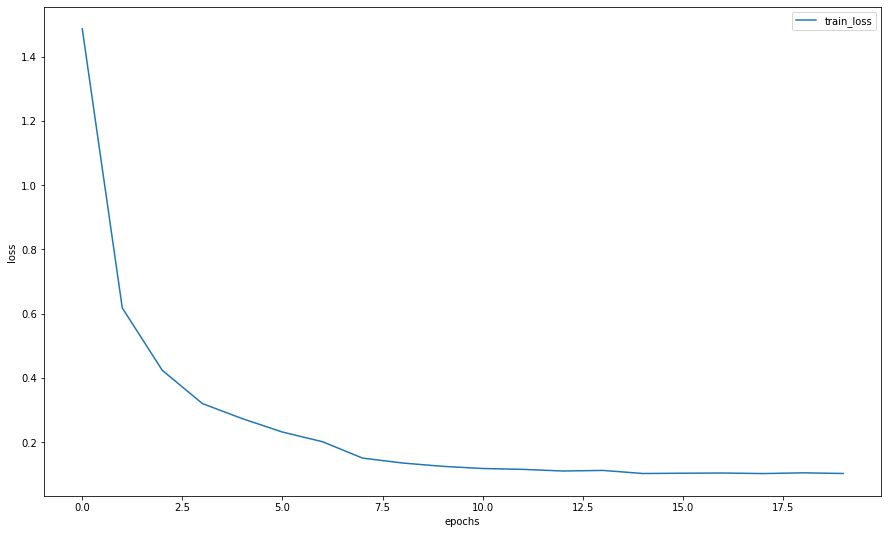

In [65]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [1]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("baseline_aug.csv", index=False)

Результат выше 95%. К сожелению полетел GPU на Google Colab и из-за этого не удолось доделать все до конца.